<a href="https://colab.research.google.com/github/Uhashini/HandwrittenSymbolClassifier/blob/main/HandwrittenSymbolClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extract the Dataset



In [1]:
import zipfile
import os

# Define paths
zip_path = "/content/torch-it-up.zip"  # Replace with your uploaded file path
extract_path = "/content/dataset"

# Extract the zip file
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")


Dataset extracted to: /content/dataset


# Load CSV Files and Verify Data

In [16]:
import pandas as pd

# Define correct paths
train_csv_path = "/content/dataset/dataset/train.csv"
test_csv_path = "/content/dataset/dataset/test.csv"
image_folder = "/content/dataset/dataset/Dataset_Image/Dataset_Image/data/"

# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Correct the image paths
train_df["image_path"] = train_df["image_path"].apply(lambda x: os.path.join(image_folder, os.path.basename(x)))
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join(image_folder, os.path.basename(x)))

# Verify a sample image
sample_image = train_df.iloc[0, 0]
print("Sample image path:", sample_image)
print("Does this file exist?", os.path.exists(sample_image))


Sample image path: /content/dataset/dataset/Dataset_Image/Dataset_Image/data/v2-118246.png
Does this file exist? True


# Image Preprocessing & DataLoader Setup

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for better training
])

# Custom PyTorch Dataset class
class MathSymbolsDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        self.dataframe = dataframe
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name).convert('L')  # Open image

        if self.transform:
            image = self.transform(image)

        if self.train:
            label = int(self.dataframe.iloc[idx, 1])  # Get label for training
            return image, label
        else:
            example_id = int(self.dataframe.iloc[idx, 2])  # Test set (no labels)
            return image, example_id

# Create dataset objects
train_dataset = MathSymbolsDataset(train_df, transform=transform, train=True)
test_dataset = MathSymbolsDataset(test_df, transform=transform, train=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Train dataset size: {len(train_dataset)}")
print(f"✅ Test dataset size: {len(test_dataset)}")


✅ Train dataset size: 134586
✅ Test dataset size: 33647


# Define the CNN Model

In [18]:
import torch.nn as nn
import torch.optim as optim

# Define CNN model
class SymbolClassifierCNN(nn.Module):
    def __init__(self, num_classes=369):
        super(SymbolClassifierCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),  # Flattened 32x32 image
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = self.fc_layers(x)
        return x

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SymbolClassifierCNN().to(device)

print(model)  # Print model summary


SymbolClassifierCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3

In [20]:
print("Max label:", train_df["label"].max())
print("Min label:", train_df["label"].min())
print("Unique labels:", train_df["label"].nunique())


Max label: 1400
Min label: 31
Unique labels: 369


In [21]:
print("Unique labels in dataset:", sorted(train_df["label"].unique())[:20])  # Show first 20 labels


Unique labels in dataset: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [22]:
# Shift labels so that they start from 0 instead of 31
train_df["label"] = train_df["label"] - 31

# Verify the fix
print("Updated Unique Labels:", sorted(train_df["label"].unique()))
print("Max label after fix:", train_df["label"].max())  # Should be 368
print("Min label after fix:", train_df["label"].min())  # Should be 0



Updated Unique Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 223, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 477, 479, 480, 481, 482, 483, 486, 489, 490, 492, 493, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 513, 518, 519, 522, 524, 531, 533, 543, 546, 551, 552, 553, 560, 564, 569, 570, 572, 573, 574, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 589, 590, 591, 599, 600, 603, 604, 605, 608, 609, 613, 616, 619, 630, 640, 647, 648, 652, 653, 667, 680, 681, 682, 685, 

In [23]:
import numpy as np

# Get unique labels sorted
unique_labels = sorted(train_df["label"].unique())

# Create a mapping dictionary (old label → new index)
label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

# Apply mapping to train dataset
train_df["label"] = train_df["label"].map(label_map)

# Verify fixed labels
print("Updated Unique Labels:", sorted(train_df["label"].unique()))
print("Max label after fix:", train_df["label"].max())  # Should be 368
print("Min label after fix:", train_df["label"].min())  # Should be 0


Updated Unique Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

# Training the Model

In [26]:
# Create dataset with fixed labels
train_dataset = MathSymbolsDataset(train_df, transform=transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# Training loop
num_epochs = 10  # Increase for better performance

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("✅ Training complete! 🎉")


Epoch [1/10], Loss: 0.7324
Epoch [2/10], Loss: 0.6672
Epoch [3/10], Loss: 0.6256
Epoch [4/10], Loss: 0.5939
Epoch [5/10], Loss: 0.5561
Epoch [6/10], Loss: 0.5306
Epoch [7/10], Loss: 0.5116
Epoch [8/10], Loss: 0.4870
Epoch [9/10], Loss: 0.4678
Epoch [10/10], Loss: 0.4477
✅ Training complete! 🎉


# Run Inference on the Test Set





In [27]:
import pandas as pd

# Set model to evaluation mode
model.eval()

# Store predictions
predictions = []

with torch.no_grad():
    for images, example_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)  # Get highest probability class

        # Store predictions
        for example_id, label in zip(example_ids, predicted_labels.cpu().numpy()):
            predictions.append((example_id, label))

# Convert to DataFrame
submission_df = pd.DataFrame(predictions, columns=["example_id", "label"])

# Save to CSV
submission_df.to_csv("submission.csv", index=False)

print("Predictions saved to submission.csv!")


Predictions saved to submission.csv!


# View First Few Predictions

In [28]:
import pandas as pd

# Load the submission file
submission_df = pd.read_csv("submission.csv")

# Display first 10 rows
print(submission_df.head(10))


       example_id  label
0  tensor(114921)    227
1  tensor(121504)    146
2   tensor(74325)    131
3   tensor(30262)    270
4  tensor(109694)    211
5  tensor(153893)     73
6  tensor(102807)    189
7   tensor(23294)     38
8  tensor(123049)    250
9   tensor(94755)    172


# Split Training Data into Train & Validation Sets

In [29]:
from sklearn.model_selection import train_test_split

# Split train data (80% training, 20% validation)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

# Create datasets
train_dataset = MathSymbolsDataset(train_data, transform=transform, train=True)
val_dataset = MathSymbolsDataset(val_data, transform=transform, train=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


✅ Training samples: 107668, Validation samples: 26918


In [31]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Compute Training Accuracy



In [33]:
# Compute Training Accuracy
model.eval()
correct_train = 0
total_train = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

# Compute final training accuracy
train_accuracy = correct_train / total_train * 100
print(f" Final Training Accuracy: {train_accuracy:.2f}%")


 Final Training Accuracy: 88.70%


# Compute Validation Accuracy

In [34]:
# Compute Validation Accuracy
model.eval()
correct_val = 0
total_val = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

# Compute final validation accuracy
val_accuracy = correct_val / total_val * 100
print(f"✅ Final Validation Accuracy: {val_accuracy:.2f}%")


✅ Final Validation Accuracy: 88.64%


# Predict a Single Image & Display It

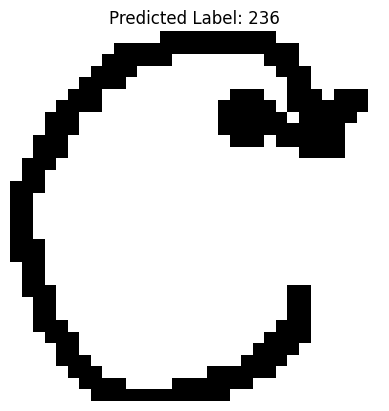

 Predicted Class: 236


In [35]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Function to predict a single image
def predict_single_image(image_path, model, class_labels=None):
    model.eval()  # Set model to evaluation mode

    # Define transformation (same as used during training)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize
    ])

    # Load image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image_transformed)
        _, predicted_label = torch.max(output, 1)

    predicted_label = predicted_label.item()  # Convert tensor to integer

    # Display the image and prediction
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

    # Return the predicted label
    return predicted_label

# Example usage
image_path = "/content/dataset/dataset/Dataset_Image/Dataset_Image/data/v2-118246.png"  # Replace with any image path
predicted_class = predict_single_image(image_path, model)

print(f" Predicted Class: {predicted_class}")
